In [1]:
import networkx as nx
import pickle
import matplotlib.pyplot as plt
import numpy as np
import random
from tabulate import tabulate
from networkx.algorithms import community
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import label_propagation_communities

In [2]:
artists_num = 18745

user_artists = []
with open('user_artists.dat', 'r') as f:
    d = f.readlines()
    for i in d:
        k = i.rstrip().split("\t")
        user_artists.append(k) 

user_artists = np.array(user_artists, dtype='O')
user_artists = user_artists[1:]
user_taggedartists = []
with open('user_taggedartists.dat', 'r') as f:
    d = f.readlines()
    for i in d:
        k = i.rstrip().split("\t")
        user_taggedartists.append(k) 
user_taggedartists = np.array(user_taggedartists, dtype='O')
user_taggedartists = user_taggedartists[1:]
print(user_artists)
print(user_taggedartists)
print(user_artists.size)
print(user_taggedartists.size)

[['2' '51' '13883']
 ['2' '52' '11690']
 ['2' '53' '11351']
 ...
 ['2100' '18728' '281']
 ['2100' '18729' '280']
 ['2100' '18730' '263']]
[['2' '52' '13' '1' '4' '2009']
 ['2' '52' '15' '1' '4' '2009']
 ['2' '52' '18' '1' '4' '2009']
 ...
 ['2100' '16437' '2087' '1' '7' '2010']
 ['2100' '16437' '2801' '1' '5' '2010']
 ['2100' '16437' '3335' '1' '7' '2010']]
278502
1118874


In [3]:
def find_rated_artists_and_tags(community):
    rated_artists = dict()
    tags = dict()
    for user in community:
        # Get artists listened to by the user
        for i in user_artists[1:]:
            if i[0] != str(user):
                continue
            if i[1] in rated_artists.keys():
                rated_artists[i[1]] = rated_artists[i[1]] + 1
            else:
                rated_artists[i[1]] = 1
        for i in user_taggedartists[1:]:
            if i[0] != str(user):
                continue
            if i[2] in tags.keys():
                tags[i[2]] = tags[i[2]] + 1
            else:
                tags[i[2]] = 1
    return rated_artists, tags

def get_max_key(dict):
    value = list(dict.values())
    key = list(dict.keys())
    position = value.index(max(value))
    return key[position]

def find_top_artists_tags(artists, tags, top):
    top_artists = []
    top_tags = []
    for i in range(top):
        current_artist = get_max_key(artists)
        top_artists.append(current_artist)
        artists.pop(current_artist)
        current_tag = get_max_key(tags)
        top_tags.append(current_tag)
        tags.pop(current_tag)
    return top_artists, top_tags

def node_artist_tag(user):
    artists = dict()
    tags = dict()
    for i in user_taggedartists:
        if i[0] != str(user):
            continue
        if i[1] in artists.keys():
            artists[i[1]] = artists[i[1]] + 1
        else:
            artists[i[1]] = 1
        if i[2] in tags.keys():
            tags[i[2]] = tags[i[2]] + 1
        else:
            tags[i[2]] = 1
    if len(artists) == 0:
        return 0
    return set(artists.keys()), set(tags.keys()), get_max_key(artists), get_max_key(tags)

def node_similarity(a, b):
    similarity = 0
    if a[3] == b[3]:
        similarity = similarity + 0.1  
    if a[2] == b[2]:
        similarity = similarity + 0.1
    similarity = similarity + len(a[0] & b[0])/len(a[0] | b[0]) * 0.4 + len(a[1] & b[1])/len(a[1] | b[1]) * 0.4
    return similarity

def find_tag_artist(artist):
    tags = dict()
    for i in user_taggedartists:
        if i[1] != str(artist):
            continue
        if i[2] in tags.keys():
            tags[i[2]] = tags[i[2]] + 1
        else:
            tags[i[2]] = 1
    return set(tags.keys())

def artists_similarity(a, b):
    return len(a & b)/len(a | b)

1)  Considering the user_friends.dat generate the friendship network among users..

In [4]:
G = nx.read_edgelist("user_friends.dat") 

 2)  Write a script to calculate various statistical properties of the generated network, including: 
the number of edges, the magnitude of the largest component, the count and sizes of 
components, the network's diameter, average path length, and average clustering coefficient. 
Present the findings on a Table.


In [5]:
edges_num = G.number_of_edges()
components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
F = G.subgraph(list(sorted(nx.connected_components(G), key=len, reverse=True)[0]))
largest_cc = F.number_of_nodes()
diameter_largest_cc = nx.diameter(F)
average_path_length = nx.average_shortest_path_length(F)
average_clustering_coefficient = nx.average_clustering(G)

In [6]:
print(tabulate([['number of edges', edges_num]
                , ['the magnitude of the largest component', largest_cc]
                , ['the count of components', len(components)]
                , ['the size of components', components]
                , ['network diameter', 'infinity']
                , ['network diameter of largest component', diameter_largest_cc]
                , ['average path length', 'infinity']
                , ['average path length of largest component', average_path_length]
                , ['average clustering coefficient', average_clustering_coefficient]]
                , headers=['Statistical Properties', 'Number']))

Statistical Properties                    Number
----------------------------------------  ---------------------------------------------------------------
number of edges                           12717
the magnitude of the largest component    1843
the count of components                   20
the size of components                    [1843, 7, 4, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
network diameter                          infinity
network diameter of largest component     9
average path length                       infinity
average path length of largest component  3.5186275740057016
average clustering coefficient            0.18654479547922223


 3) Utilize NetworkX methodologies to identify user groups within the network. Employ the 
Label Propagation Algorithm (LPA) and the Girvan-Newman Algorithm for this purpose.
Additionally, leverage NetworkX to assess the effectiveness of these communities usin 
performance metrics, and subsequently, compare the outcomes of both apprc.ess

In [5]:
lpa_communities = list(community.label_propagation_communities(G))
print("Communities identified using Label Propagation Algorithm:")
print(lpa_communities)

Communities identified using Label Propagation Algorithm:
[{'831', '1206', '2057', '903', '469', '1188', '1029', '1396', '1924', '1143', '482', '1678', '1462', '306', '844', '547', '1797', '1820', '137', '1800', '1246', '1588', '1408', '1425', '760', '399', '1403', '1864', '127', '1549', '1279', '1213', '2061', '611', '756', '100', '2048', '38', '1274', '1643', '1690', '2070', '851', '662', '361', '1064', '2066', '493', '743', '1183', '899', '997', '1855', '254', '1758', '1253', '480', '1236', '108', '702', '366', '1319', '1135', '1217', '1450', '1469', '631', '1536', '369', '2097', '1205', '1290', '146', '1544', '289', '1873', '78', '1541', '550', '1401', '1272', '1659', '1327', '2053', '619', '1723', '926', '810', '157', '128', '473', '596', '1149', '1675', '814', '1299', '2038', '87', '453', '812', '933', '856', '540', '2000', '1915', '7', '1404', '296', '938', '225', '982', '1055', '3', '1856', '1802', '1722', '47', '91', '1312', '1576', '930', '1776', '931', '377', '560', '1805', 

In [6]:
gn_communities = girvan_newman(G)
print("\nCommunities identified using Girvan-Newman Algorithm:")
node_groups = []
for com in next(gn_communities):
    node_groups.append(list(com))
print(node_groups)


Communities identified using Girvan-Newman Algorithm:
[['831', '1206', '2057', '903', '469', '1188', '1029', '1396', '1692', '1924', '1143', '482', '1678', '1462', '306', '897', '1431', '844', '547', '1797', '1820', '1800', '137', '1246', '1588', '1408', '1425', '760', '399', '1403', '1864', '127', '1549', '1279', '1213', '1324', '2061', '611', '756', '100', '2048', '38', '1274', '1643', '1690', '2070', '851', '662', '361', '1064', '2090', '2066', '743', '1183', '899', '493', '997', '206', '1855', '1254', '254', '1758', '1253', '480', '1236', '108', '702', '366', '1319', '1135', '1217', '1657', '1450', '586', '1807', '1469', '631', '1354', '1536', '369', '1205', '2097', '1290', '435', '146', '1544', '289', '1873', '78', '1541', '550', '1401', '1272', '1659', '1327', '2053', '619', '1723', '926', '810', '157', '128', '473', '596', '1149', '1675', '2038', '453', '814', '87', '1299', '812', '933', '856', '540', '2000', '1322', '1915', '7', '1404', '296', '938', '1925', '225', '982', '105

[0.9999213651018322, 0.988597939765668] [0.06335563026375074, 0.21643413834084452]


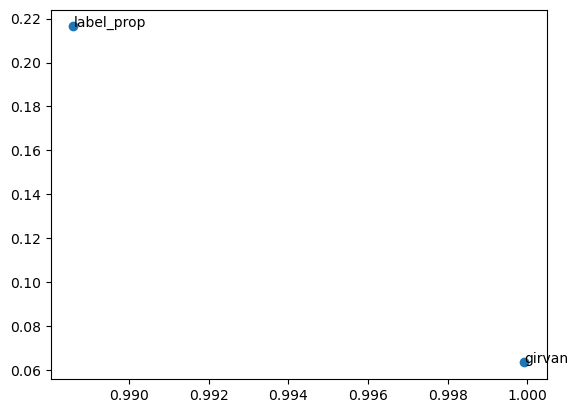

In [7]:
partitions = [node_groups, lpa_communities]
cov = []
per = []
for part in partitions:
    coverage, performance = nx.community.partition_quality(G, part)
    cov.append(coverage)
    per.append(performance)
titles = ['girvan', 'label_prop']
plt.scatter(cov, per)
for i, txt in enumerate(titles):
    plt.annotate(txt, (cov[i], per[i])) 
print(cov, per)

 4)  Try to find rated artists and tags within each community, then analyze and compare the 
various approaches. Are there any shared artists or tags which overlap between all detected 
communities? Try to identify these shared items and tags.

In [26]:
lpa_rated_artists_tags = []
for community in lpa_communities:
    if len(community) > 10:
        lpa_rated_artists_tags.append(find_rated_artists_and_tags(community))

gn_rated_artists_tags = []
for community in node_groups:
    if len(community) > 10:
        gn_rated_artists_tags.append(find_rated_artists_and_tags(community))

In [31]:
print(gn_rated_artists_tags[0][1])

{'18': 4631, '319': 189, '73': 7408, '5746': 1, '192': 2277, '39': 2733, '311': 296, '321': 340, '5745': 1, '7848': 2, '4': 301, '5': 567, '91': 641, '185': 1033, '209': 171, '537': 22, '1392': 14, '7850': 1, '7853': 1, '7854': 1, '7855': 1, '88': 700, '829': 692, '1071': 15, '7849': 1, '7852': 1, '12477': 1, '3481': 1, '12476': 1, '72': 1780, '76': 502, '78': 2610, '159': 84, '3774': 2, '7721': 1, '7722': 1, '81': 4370, '7725': 1, '7724': 1, '238': 665, '7720': 1, '6253': 25, '850': 579, '1097': 253, '1424': 24, '1495': 77, '4397': 35, '5094': 18, '6798': 26, '6805': 13, '6815': 7, '5083': 11, '6794': 37, '6796': 29, '6808': 15, '16': 1576, '25': 2777, '184': 937, '330': 22, '4915': 17, '6795': 31, '6804': 17, '6797': 20, '6811': 11, '6809': 9, '6813': 15, '670': 46, '6799': 14, '6803': 16, '6817': 10, '6801': 18, '6807': 14, '508': 619, '299': 289, '6816': 8, '6819': 7, '6810': 8, '6800': 7, '6812': 10, '6806': 10, '1560': 9, '252': 38, '625': 1091, '6802': 15, '98': 111, '595': 13, 

In [33]:
print("With Label Propagation Algorithm (LPA), the rated artists and tag is:")
for i in lpa_rated_artists_tags:
    print(f"artist: {list(i[0].keys())}, tag: {list(i[1].keys())}")

print("With Girvan-Newman Algorithm, the rated artists and tag is:")
for i in gn_rated_artists_tags:
    print(f"artist: {list(i[0].keys())}, tag: {list(i[1].keys())}")

With Label Propagation Algorithm (LPA), the rated artists and tag is:
artist: ['57', '63', '66', '67', '69', '72', '77', '86', '155', '157', '429', '511', '518', '533', '601', '706', '871', '903', '959', '975', '993', '1001', '1122', '1412', '1463', '1793', '2524', '3307', '3863', '4155', '4156', '5254', '6128', '7068', '7157', '7874', '8853', '9685', '9888', '10176', '10182', '10461', '10462', '10463', '10464', '10465', '10466', '10467', '10468', '10469', '163', '227', '234', '554', '607', '707', '724', '726', '841', '868', '917', '957', '1202', '1358', '1369', '1372', '1639', '2013', '2075', '2265', '2343', '2787', '3302', '3470', '3774', '5692', '9529', '13106', '13107', '13108', '13109', '13110', '13111', '13112', '13113', '13114', '13115', '13116', '13117', '13118', '13119', '13120', '13121', '13122', '13123', '13124', '13125', '56', '228', '229', '300', '324', '333', '344', '362', '412', '437', '466', '471', '488', '499', '536', '722', '728', '730', '734', '757', '891', '898', '1

 5) Try to identify the top-10 popular shared artists and tags within each community. 
Subsequently, explore potential trends among user communities based on the popular artists
or tags specific to each community.o  


In [12]:
lpa_top = []
gn_top = []
for i in lpa_rated_artists_tags:
    lpa_top.append(find_top_artists_tags(i[0].copy(), i[1].copy(), 10))
for i in gn_rated_artists_tags:
    gn_top.append(find_top_artists_tags(i[0], i[1].copy(), 10))

print("With Label Propagation Algorithm (LPA), the rated artists and tag is:")
for i in lpa_top:
    print(f"artist: {i[0]}, tag: {i[1]}")

print("With Girvan-Newman Algorithm, the rated artists and tag is:")
for i in gn_top:
    print(f"artist: {i[0]}, tag: {i[1]}")

With Label Propagation Algorithm (LPA), the rated artists and tag is:
artist: ['207', '709', '969', '173', '441', '1048', '2818', '7', '208', '428'], tag: ['370', '216', '210', '81', '102', '177', '376', '352', '73', '194']
artist: ['163', '2312', '1109', '506', '2300', '6961', '196', '2338', '707', '2339'], tag: ['81', '14', '192', '18', '130', '167', '73', '13', '424', '191']
With Girvan-Newman Algorithm, the rated artists and tag is:


6) Rather than creating a user graph using user_friends.dat, consider generating a user graph 
based on user similarity. Suggest a script to compute user similarity based on their 
interactions (common shared items/tags) found in user_taggedartists.dat. Once the 
Pearson similarity measure is computed, you can define a threshold to construct the bipartite 
graph. This graph will feature an edge between two nodes if their similarity exceeds the 
defined threshold.

In [14]:
list_artist_tag = dict()
for node in G.nodes():
    list_artist_tag[node] = node_artist_tag(node)

In [21]:
node = list(list_artist_tag.keys())
i = 0
threshold = 0.25
for i in range(len(node)):
    for j in range(i+1, len(node)):
        similarity = node_similarity(list_artist_tag[node[i]], list_artist_tag[node[j]])
        if similarity > threshold:
            G.add_edge(node[i], node[j])

7 ) Repeat tasks 2-6 for this new graph.

7.2 

In [22]:
edges_num = G.number_of_edges()
components = [len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)]
F = G.subgraph(list(sorted(nx.connected_components(G), key=len, reverse=True)[0]))
largest_cc = F.number_of_nodes()
diameter_largest_cc = nx.diameter(F)
average_path_length = nx.average_shortest_path_length(F)
average_clustering_coefficient = nx.average_clustering(G)

In [23]:
print(tabulate([['number of edges', edges_num]
                , ['the magnitude of the largest component', largest_cc]
                , ['the count of components', len(components)]
                , ['the size of components', components]
                , ['network diameter', 'infinity']
                , ['network diameter of largest component', diameter_largest_cc]
                , ['average path length', 'infinity']
                , ['average path length of largest component', average_path_length]
                , ['average clustering coefficient', average_clustering_coefficient]]
                , headers=['Statistical Properties', 'Number']))

Statistical Properties                    Number
----------------------------------------  ------------------------------------------------------
number of edges                           13689
the magnitude of the largest component    1850
the count of components                   17
the size of components                    [1850, 7, 4, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]
network diameter                          infinity
network diameter of largest component     9
average path length                       infinity
average path length of largest component  3.472379810854662
average clustering coefficient            0.18645827501248022


7.3

Communities identified using Label Propagation Algorithm:
[{'friendID', 'userID'}, {'1921', '413', '492', '342', '218', '2009', '1817', '1547', '1373', '1371', '269', '1804', '2038', '267', '1159', '549', '824', '1170', '652', '667', '1522', '1977', '929', '604', '185', '1494', '1490', '1311', '573', '1981', '1395', '541', '543', '1321', '1619', '1188', '366', '1032', '2061', '757', '1783', '1745', '1475', '493', '321', '1379', '1298', '172', '194', '1094', '1665', '1600', '1501', '1999', '451', '2091', '628', '693', '1156', '1340', '770', '178', '723', '773', '1678', '175', '1958', '779', '1332', '151', '1848', '1931', '1138', '1139', '844', '1736', '1377', '306', '1836', '1811', '1790', '911', '606', '609', '1857', '1839', '1119', '234', '1831', '1912', '129', '694', '1691', '1942', '1518', '1126', '423', '79', '1834', '1018', '16', '208', '718', '1733', '90', '295', '1451', '214', '95', '899', '663', '1215', '787', '2022', '1466', '1761', '1273', '795', '436', '154', '1418', '367', 

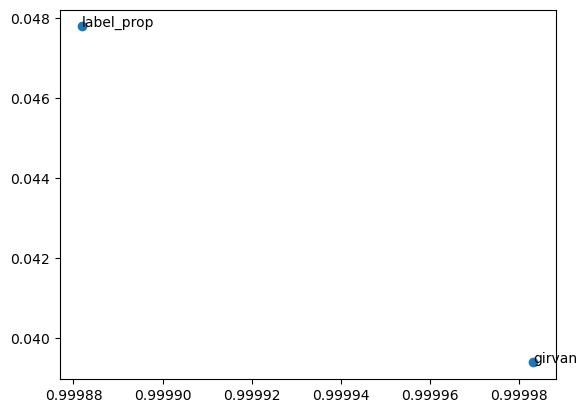

In [26]:
lpa_communities = list(label_propagation_communities(G))
print("Communities identified using Label Propagation Algorithm:")
print(lpa_communities)

gn_communities = girvan_newman(G)
print("\nCommunities identified using Girvan-Newman Algorithm:")
node_groups = []
for com in next(gn_communities):
    node_groups.append(list(com))
print(node_groups)

partitions = [node_groups, lpa_communities]
cov = []
per = []
for part in partitions:
    coverage, performance = nx.community.partition_quality(G, part)
    cov.append(coverage)
    per.append(performance)
titles = ['girvan', 'label_prop']
plt.scatter(cov, per)
for i, txt in enumerate(titles):
    plt.annotate(txt, (cov[i], per[i])) 
print(cov, per)

 7.4)  Try to find rated artists and tags within each community, then analyze and compare the 
various approaches. Are there any shared artists or tags which overlap between all detected 
communities? Try to identify these shared items and tags.

In [10]:
lpa_rated_artists_tags = []
for community in lpa_communities[1:]:
    if len(community) > 10:
        lpa_rated_artists_tags.append(find_rated_artists_and_tags(community))

gn_rated_artists_tags = []
for community in node_groups[1:]:
    if len(community) > 10:
        gn_rated_artists_tags.append(find_rated_artists_and_tags(community))

In [11]:
lpa_most = []
gn_most = []
for i in lpa_rated_artists_tags:
    lpa_most.append(find_top_artists_tags(i[0].copy(), i[1].copy(), 1))
for i in gn_rated_artists_tags:
    gn_most.append(find_top_artists_tags(i[0].copy(), i[1].copy(), 1))

print("With Label Propagation Algorithm (LPA), the rated artists and tag is:")
for i in lpa_most:
    print(f"artist: {i[0][0]}, tag: {i[1][0]}")

print("With Girvan-Newman Algorithm, the rated artists and tag is:")
for i in gn_most:
    print(f"artist: {i[0][0]}, tag: {i[1][0]}")

With Label Propagation Algorithm (LPA), the rated artists and tag is:
artist: 207, tag: 370
artist: 163, tag: 81
With Girvan-Newman Algorithm, the rated artists and tag is:


 7.5) Try to identify the top-10 popular shared artists and tags within each community. 
Subsequently, explore potential trends among user communities based on the popular artists
or tags specific to each community.o  


In [12]:
lpa_top = []
gn_top = []
for i in lpa_rated_artists_tags:
    lpa_top.append(find_top_artists_tags(i[0].copy(), i[1].copy(), 10))
for i in gn_rated_artists_tags:
    gn_top.append(find_top_artists_tags(i[0], i[1].copy(), 10))

print("With Label Propagation Algorithm (LPA), the rated artists and tag is:")
for i in lpa_top:
    print(f"artist: {i[0]}, tag: {i[1]}")

print("With Girvan-Newman Algorithm, the rated artists and tag is:")
for i in gn_top:
    print(f"artist: {i[0]}, tag: {i[1]}")

With Label Propagation Algorithm (LPA), the rated artists and tag is:
artist: ['207', '709', '969', '173', '441', '1048', '2818', '7', '208', '428'], tag: ['370', '216', '210', '81', '102', '177', '376', '352', '73', '194']
artist: ['163', '2312', '1109', '506', '2300', '6961', '196', '2338', '707', '2339'], tag: ['81', '14', '192', '18', '130', '167', '73', '13', '424', '191']
With Girvan-Newman Algorithm, the rated artists and tag is:


8) Suggest appropriate metrics to compare the two graphs of 1) and 6)

In [31]:
artists_tag = dict()
for i in range(artists_num):
    artists_tag[str(i)] = find_tag_artist(i)
print(artists_tag)

KeyboardInterrupt: 

9) In this step, our aim is to generate an attributed network of artists. Each artist will be 
represented as a node, and their shared tags (from user_taggedartists.dat) will serve as 
their attributes. Next, suggest a node similarity measure suitable for this new attributed 
network. Subsequently, proceed with generating the graph based on this calculated node 
similarities.

10)  Find top-10 popular nodes in this network based on three node centrality measure of 
Degree, Betweenness and Eigenvector. 

11) In this step, we aim to calculate the popularity of each artist based on the user interaction matrix extracted from user_taggedartists.dat. To achieve this, we will count the number of user_artist_tag rows for each artist, considering it as a measure of popularity. Artists with more recorded rows will be deemed more popular. Write a script to draw a histogram depicting the yearly 10 popular artists and visualize the graph and compare the results of this popular artist with previously calculated popular nodes in Step 10.


12) Identify relevant literature to provide analysis and discussion on the findings, while also 
highlighting potential limitations of the study.